In [1]:
import os
# os.environ['CUDA_VISIBLE_DEVICES'] = '7'
import cv2
import torch
import numpy as np
from PIL import Image
from matplotlib import pyplot as plt
from matplotlib import patches
import math

import open_clip
from f3rm.minimal.interface import NERFinterface
from f3rm.minimal.opt import NERFOpt
from f3rm.features.clip_extract import extract_clip_features, CLIPArgs
from f3rm.minimal.homography import Homography
from f3rm.minimal.utils import run_pca, viz_pca3, compute_similarity_text2vis
from f3rm.minimal.utils import exp_to_homo_T, homo_T_to_exp, se3_distance, cluster_xyz

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
config_path = "outputs/ahgroom_colmap/f3rm/2025-04-14_190026/config.yml"
nerfint = NERFinterface(config_path, device=device)

Using mmap cache: CLIP (18 shards)

Loading latest checkpoint from load_dir

✅ Done loading checkpoint from outputs/ahgroom_colmap/f3rm/2025-04-14_190026/nerfstudio_models/step-000119999.ckpt

In [3]:
frame1_c2w_44 = NERFOpt.get_init_frame(device=device)
c2w_new_44 = NERFOpt.get_cbev2w_44(device=device)
c2w_new = torch.as_tensor(c2w_new_44[:3, :4]).float().cpu()
# FX, FY, WIDTH, HEIGHT = 1150.0, 1150.0, 1920, 1440
FX, FY, WIDTH, HEIGHT = 465.0, 465.0, 960, 540
K_np = nerfint.get_cam_intrinsics_nodist(fx=FX, fy=FY, width=WIDTH, height=HEIGHT)
K = torch.from_numpy(K_np).to(device, dtype=torch.float32)

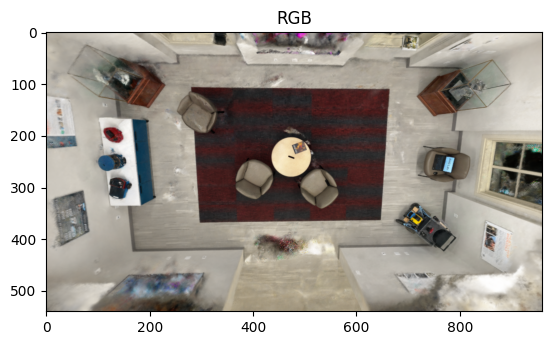

In [4]:
outputs, ray_bundle = nerfint.get_custom_camera_outputs(
    fx=FX,
    fy=FY,
    width=WIDTH,
    height=HEIGHT,
    c2w=c2w_new,
    fars=10.0,
    nears=1.1,
    return_rays=True
)
img = (outputs["rgb"].cpu().numpy() * 255).astype(np.uint8)
plt.imshow(img)
plt.title("RGB")
plt.show()

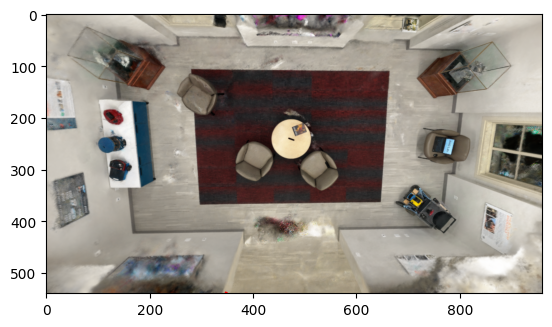

In [5]:
img_copy = img.copy()
bevpcs_coords = NERFOpt.c2w_pose_viz(frame1_c2w_44, c2w_new_44, K, WIDTH, HEIGHT, device=device).cpu().numpy()
cv2.arrowedLine(img_copy, (bevpcs_coords[0][0], bevpcs_coords[0][1]), (bevpcs_coords[1][0], bevpcs_coords[1][1]), (255, 0, 0), 2, tipLength=0.25)
plt.imshow(img_copy)

In [6]:
descriptors = outputs["feature"].cpu()
descriptors.shape

torch.Size([540, 960, 768])

In [7]:
model, _, _ = open_clip.create_model_and_transforms(CLIPArgs.model_name, pretrained=CLIPArgs.model_pretrained, device=nerfint.device)
model.eval()

CLIP(
  (visual): VisionTransformer(
    (conv1): Conv2d(3, 1024, kernel_size=(14, 14), stride=(14, 14), bias=False)
    (patch_dropout): Identity()
    (ln_pre): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
    (transformer): Transformer(
      (resblocks): ModuleList(
        (0-23): 24 x ResidualAttentionBlock(
          (ln_1): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
          (attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=1024, out_features=1024, bias=True)
          )
          (ls_1): Identity()
          (ln_2): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
          (mlp): Sequential(
            (c_fc): Linear(in_features=1024, out_features=4096, bias=True)
            (gelu): QuickGELU()
            (c_proj): Linear(in_features=4096, out_features=1024, bias=True)
          )
          (ls_2): Identity()
        )
      )
    )
    (ln_post): LayerNorm((1024,), eps=1e-05, elementwise_affine=Tru

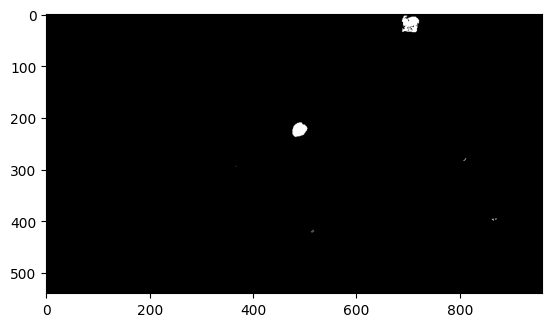

In [8]:
text_queries = ["magazine", "object"]
tokenizer = open_clip.get_tokenizer(CLIPArgs.model_name)
text = tokenizer(text_queries).to(nerfint.device)
text_features = model.encode_text(text)
text_embds = text_features.cpu()
sims = compute_similarity_text2vis(descriptors, text_embds, has_negatives=True, softmax_temp=1.0).squeeze()
# plt.imshow(sims.cpu().numpy(), cmap="turbo")
# plt.show()
magazine_mask = (sims.cpu().numpy() > 0.502)
plt.imshow(magazine_mask, cmap="gray")
plt.show()

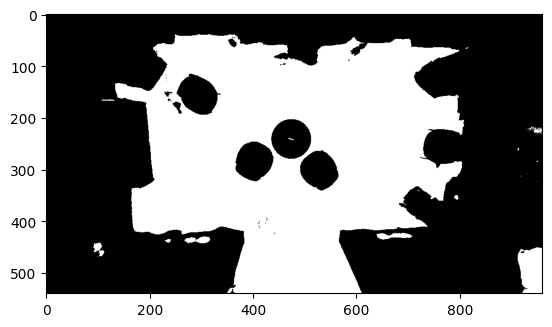

In [9]:
text_queries = ["floor", "object"]
tokenizer = open_clip.get_tokenizer(CLIPArgs.model_name)
text = tokenizer(text_queries).to(nerfint.device)
text_features = model.encode_text(text)
text_embds = text_features.cpu()
sims = compute_similarity_text2vis(descriptors, text_embds, has_negatives=True, softmax_temp=1.0).squeeze()
# plt.imshow(sims.cpu().numpy(), cmap="turbo")
# plt.show()
floor_mask = (sims.cpu().numpy() > 0.502)
plt.imshow(floor_mask, cmap="gray")
plt.show()

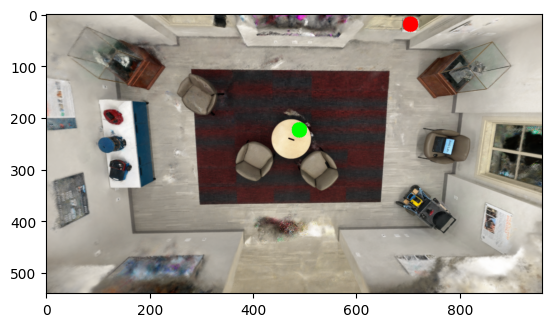

In [10]:
depth = outputs["depth"].squeeze(-1)        # (H,W)
origins = ray_bundle.origins.squeeze(0)      # (H,W,3)
directions = ray_bundle.directions.squeeze(0)   # (H,W,3)
pts_nerf = origins + directions * depth.unsqueeze(-1)
magazine_pts = pts_nerf[magazine_mask].cpu().numpy()
labels, stats = cluster_xyz(magazine_pts, max_auto_K=5)
nerfworld_coords = torch.stack([
    torch.from_numpy(stats[0]['center']).to(device, dtype=torch.float32),
    torch.from_numpy(stats[1]['center']).to(device, dtype=torch.float32)
])
bevpcs_coords = Homography.general_project_A_to_B(nerfworld_coords, torch.linalg.inv(c2w_new_44), device=device)
bevccsnormal_coords = Homography.general_project_A_to_B(bevpcs_coords, NERFinterface.get_nerf_ccs_to_normal_ccs_T(device=device), device=device)
bevpcs_coords, _ = Homography.projectCCStoPCS(bevccsnormal_coords, K, WIDTH, HEIGHT, d=None, mode="none", device=device)

img_copy = img.copy()
cv2.circle(img_copy, (int(bevpcs_coords[0][0]), int(bevpcs_coords[0][1])), 15, (255, 0, 0), -1)
cv2.circle(img_copy, (int(bevpcs_coords[1][0]), int(bevpcs_coords[1][1])), 15, (0, 255, 0), -1)
plt.imshow(img_copy)
plt.show()

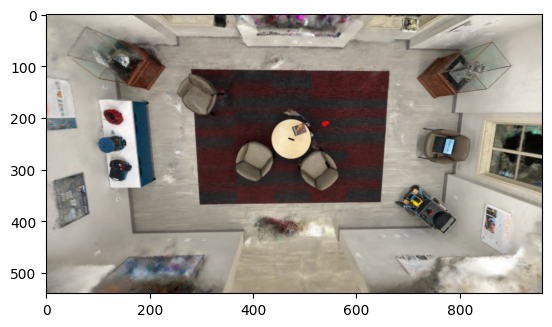

In [11]:
img_copy = img.copy()
bevpcs_coords = NERFOpt.c2w_pose_viz(NERFOpt.generate_new_pose(frame1_c2w_44, c2w_new_44, px=0.5, py=1.1, ry=90, device=device), 
                                     c2w_new_44, K, WIDTH, HEIGHT, device=device).cpu().numpy()
cv2.arrowedLine(img_copy, (bevpcs_coords[0][0], bevpcs_coords[0][1]), (bevpcs_coords[1][0], bevpcs_coords[1][1]), (255, 0, 0), 6, tipLength=0.35)
plt.imshow(img_copy)

In [25]:
# fpose_44 = NERFOpt.generate_new_pose(frame1_c2w_44, c2w_new_44, px=0.385, py=1.091, ry=90, device=device)
# fpose_44 = NERFOpt.generate_new_pose(frame1_c2w_44, c2w_new_44, px=0.224 , py=1.059, ry=90, device=device)
# fpose_44 = NERFOpt.generate_new_pose(frame1_c2w_44, c2w_new_44, px=0.475, py=0.984, ry=np.rad2deg(-0.552 * 10.0), device=device)
fpose_44 = NERFOpt.generate_new_pose(frame1_c2w_44, c2w_new_44, px=0.413, py=1.209, ry=np.rad2deg(0.138 * 10.0), device=device)

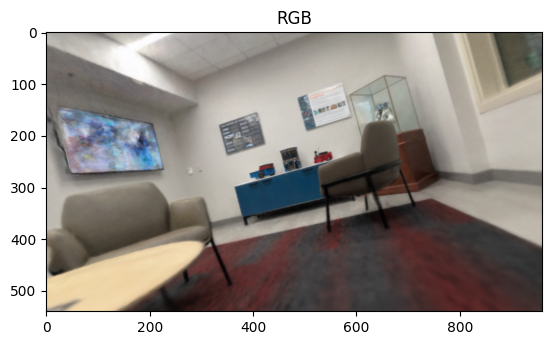

In [26]:
outputs2 = nerfint.get_custom_camera_outputs(
    fx=FX,
    fy=FY,
    width=WIDTH,
    height=HEIGHT,
    c2w=fpose_44[:3, :4],
    # fars=10.0,
    # nears=1.1,
)
img2 = (outputs2["rgb"].cpu().numpy() * 255).astype(np.uint8)
plt.imshow(img2)
plt.title("RGB")
plt.show()

In [ ]:
torch.norm(nerfworld_coords[0] - nerfworld_coords[1]).item()

In [ ]:
nerfopt_factory = NERFOpt()
obj_fn = nerfopt_factory(device)

In [ ]:
obj_fn(np.array([0.5, 1.1, 90]))

In [ ]:
obj_fn(np.array([0.385, 1.091, 90]))

In [ ]:
obj_fn(np.array([0.519, -27.647, 90.001]))

In [29]:
x = torch.from_numpy(np.array([0.385, 1.091, 90])).to(device, dtype=torch.float32)
newc2w_pose_44 = NERFOpt.generate_new_pose(frame1_c2w_44, c2w_new_44, px=x[0].item(), py=x[1].item(), ry=x[2].item(), device=device)

In [ ]:
torch.norm(newc2w_pose_44[:3, 3] - nerfworld_coords[1])

In [ ]:
import numpy as np
import matplotlib.pyplot as plt


def smooth_peak(x: float,
                l: float,
                h: float,
                peak: float,
                *, eps: float = 1e-3) -> float:
    """
    Smooth (Gaussian-shaped) normalizer.
    • Returns 1.0 at `peak`.
    • Falls off like a Gaussian and is hard-clipped to 0 outside (l, h).
    • `eps` sets how close to 0 the curve is at the bounds (default 1 × 10⁻³).

    Parameters
    ----------
    x : scalar or numpy array
    l : lower bound  (must be < peak)
    h : upper bound  (must be > peak)
    peak : x-value where output reaches 1.0
    eps : desired value at the bounds (0 < eps < 1).  Smaller ⇒ wider σ.
    """
    if not (l < peak < h):
        raise ValueError("Require l < peak < h")
    if not (0.0 < eps < 1.0):
        raise ValueError("eps must be in (0,1)")

    # Choose σ so that Gaussian value == eps at the bounds.
    sigma = (peak - l) / np.sqrt(2.0 * np.log(1.0 / eps))

    x = np.asanyarray(x)
    y = np.exp(-0.5 * ((x - peak) / sigma) ** 2)

    # Hard-clip outside the support region
    y = np.where((x < l) | (x > h), 0.0, y)
    return y

l, h, peak = -10, 10, 0.0
xs = np.linspace(l - 2, h + 2, 501)
ys = smooth_peak(xs, l, h, peak, eps=1e-4)

plt.figure()
plt.plot(xs, ys, label="smooth_peak()")
plt.axvline(l,   linestyle="--", alpha=.4)
plt.axvline(peak,linestyle="--", alpha=.4)
plt.axvline(h,   linestyle="--", alpha=.4)
plt.title("Smooth Gaussian-shaped profile")
plt.xlabel("x")
plt.ylabel("normalized value")
plt.tight_layout()
plt.show()


In [ ]:
feat_pca = outputs['feature_pca']

In [ ]:
plt.imshow(feat_pca.cpu().numpy(), cmap="turbo")
plt.show()

In [ ]:
outputs["rgb"][(sims.cpu().numpy() > 0.502)].shape

In [ ]:
import open3d as o3d
pcd  = nerfint.pointcloud_from_camera(fx=1150.0, fy=1150.0, width=1920, height=1440, fars=10.0, nears=1.1, c2w=c2w_new, save_feature_pca=True)
o3d.io.write_point_cloud("view2.ply", pcd)
# o3d.visualization.draw_geometries([o3d.io.read_point_cloud("exports/pcd/point_cloud.ply")])

In [ ]:
bev_full = np.asarray(Image.open("temp/bev_room.png").convert("RGB"))
bev_crop_window = bev_full[0:400, 1100:1750, :]
plt.imshow(bev_crop_window)

In [ ]:
def plot_points_on_image(image_path, points, save_path='output.png'):
    if isinstance(image_path, str):
        img = Image.open(image_path).convert('RGB')
    else:
        img = image_path.convert('RGB')
    width, height = img.size

    fig, ax = plt.subplots()
    ax.imshow(img)

    # Use default colormap
    colors = plt.cm.get_cmap('tab10')

    for i, (x, y) in enumerate(points):
        c1 = patches.Circle((x, y), 6, color=colors(3), fill=True)
        ax.add_patch(c1)
        c2 = patches.Circle((x, y), 16, color=colors(3), fill=False)
        ax.add_patch(c2)

    ax.axis('off')
    plt.tight_layout()
    if save_path is None:
        plt.show()
    else:
        plt.savefig(save_path, bbox_inches='tight', pad_inches=0)

In [ ]:
rgb_img = outputs["rgb"].cpu().numpy()
rgb_img = (rgb_img * 255).astype(np.uint8)
pil_img = Image.fromarray(rgb_img)
plot_points_on_image(pil_img, points=[(1100, 500), (1000, 500), (1020, 600), (1090, 550)], save_path=None)

In [ ]:
def generate_affordance_map(rgb_img, center_x, center_y, sigma=50):
    """
    Overlays a red affordance heatmap on the input RGB image using a 2D Gaussian centered at (center_x, center_y).
    """
    h, w, _ = rgb_img.shape
    yy, xx = np.meshgrid(np.arange(h), np.arange(w), indexing='ij')
    dist_sq = (xx - center_x) ** 2 + (yy - center_y) ** 2
    gaussian = np.exp(-dist_sq / (2 * sigma ** 2))
    gaussian = (gaussian / np.max(gaussian) * 255).astype(np.uint8)  # Normalize to [0, 255]

    red_overlay = np.zeros_like(rgb_img, dtype=np.uint8)
    red_overlay[..., 0] = gaussian  # Red channel only

    blended = cv2.addWeighted(rgb_img, 1.0, red_overlay, 1.0, 0)
    return blended

In [ ]:
redded = generate_affordance_map(rgb_img, 1350, 300, sigma=120)

In [ ]:
bothredgreen = generate_affordance_map(redded, 1100, 550, sigma=120)

In [ ]:
import open3d as o3d
# o3d.visualization.draw_geometries([o3d.io.read_point_cloud("exports/pcd/point_cloud.ply")])
pcd1 = o3d.io.read_point_cloud("exports/pcd/point_cloud.ply")

In [ ]:
pcd1.points

In [ ]:
import os

file_size = os.path.getsize("exports/pcd/point_cloud.ply")          # ≃1_060_000_000 bytes
header_size = 1024                                      # ≳1 KiB; parse to get exact
bytes_per_vertex = 27                                   # 12 B + 3 B + 12 B

N = (file_size - header_size) // bytes_per_vertex
print(f"≈{N:,} points")                                 # → about 39 260 000 points

In [ ]:
type2bytes = {
    'char':1,'uchar':1,'uint8':1,'float':4,'float32':4,'double':8,'float64':8
}

props = []
with open("exports/pcd/point_cloud.ply","rb") as f:
    while True:
        line = f.readline().decode()
        if line.startswith("element vertex"):
            N = int(line.split()[2])
        if line.startswith("property"):
            _, t, _ = line.split()
            props.append(t)
        if line.strip() == "end_header":
            header_size = f.tell()
            break

bytes_per_vertex = sum(type2bytes[t] for t in props)
computed_size = header_size + N * bytes_per_vertex

print(f"N={N:,}, bytes_per_vertex={bytes_per_vertex}, "
      f"header={header_size} B, total={computed_size/1e9:.3f} GB")
print("On-disk:", os.path.getsize("exports/pcd/point_cloud.ply")/1e9, "GB")


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# ---------------------------
# 1)  Example cost function
# ---------------------------
def himmelblau(x: np.ndarray) -> np.ndarray:
    """
    Vectorised Himmelblau’s function.
    Accepts (..., 2) shaped array and returns same leading shape.
    """
    x = np.asarray(x)
    x1 = x[..., 0]
    x2 = x[..., 1]
    return (x1**2 + x2 - 11)**2 + (x1 + x2**2 - 7)**2


# ---------------------------
# 2)  Optimisation routines
# ---------------------------
def simulated_annealing(cost, x0, *, T0=10.0, alpha=0.98,
                        step_size=0.5, max_iter=5000, rng=None):
    """
    Generic n‑dimensional simulated‑annealing optimiser.
    Returns the best point found.
    """
    if rng is None:
        rng = np.random.default_rng()
    x = np.asarray(x0, dtype=float)
    e = cost(x)
    best_x, best_e = x.copy(), e
    T = T0
    for _ in range(max_iter):
        candidate = x + rng.normal(scale=step_size, size=x.shape)
        e_cand = cost(candidate)
        dE = e_cand - e
        if dE <= 0 or rng.random() < np.exp(-dE / T):
            x, e = candidate, e_cand
            if e < best_e:
                best_x, best_e = x.copy(), e
        T *= alpha
    return best_x, best_e


def local_descent(cost, x, *, step=1e-3, max_iter=10000):
    """
    Simple coordinate search to slide downhill once SA is “cold”.
    Works for any dimensionality.
    """
    e = cost(x)
    for _ in range(max_iter):
        improved = False
        for axis in range(len(x)):
            for direction in (-1, 1):
                cand = x.copy()
                cand[axis] += direction * step
                e_cand = cost(cand)
                if e_cand < e:
                    x, e = cand, e_cand
                    improved = True
        if not improved:
            break
    return x, e


def dedup(points, tol=1e-2):
    """Merge near‑duplicate points (Euclidean distance < tol)."""
    unique = []
    for p in points:
        if all(np.linalg.norm(p - q) > tol for q in unique):
            unique.append(p)
    return unique


def find_local_minima(cost, *, n_runs=60, sa_kwargs=None, seed=0):
    rng = np.random.default_rng(seed)
    sa_kwargs = sa_kwargs or {}
    minima = []
    for _ in range(n_runs):
        start = rng.uniform(-6, 6, size=2)  # domain for Himmelblau
        x_sa, _ = simulated_annealing(cost, start, rng=rng, **sa_kwargs)
        x_ls, _ = local_descent(cost, x_sa)
        minima.append(x_ls)
    minima = dedup(minima)
    return minima


# ---------------------------
# 3)  Run pipeline
# ---------------------------
minima = find_local_minima(
    himmelblau,
    n_runs=60,
    sa_kwargs=dict(T0=15.0, alpha=0.985, step_size=0.8, max_iter=8000),
    seed=123
)

print("Distinct local minima discovered:")
for i, m in enumerate(minima, 1):
    print(f"{i:2d}: ({m[0]: .6f}, {m[1]: .6f})   cost = {himmelblau(m):.6f}")

# ---------------------------
# 4)  Visualisation
# ---------------------------
xs = ys = np.linspace(-6, 6, 400)
X, Y = np.meshgrid(xs, ys)
grid = np.stack([X, Y], axis=-1)
Z = himmelblau(grid)

plt.figure(figsize=(6, 5))
plt.imshow(Z, extent=[-6, 6, -6, 6], origin='lower', aspect='auto')
mins = np.array(minima)
plt.scatter(mins[:, 0], mins[:, 1], marker='x', s=80, linewidths=2)
plt.title('Himmelblau function with discovered local minima (×)')
plt.xlabel('x')
plt.ylabel('y')
plt.tight_layout()
plt.show()


Distinct minima:
 1: ( 2.999874,  1.999925)   cost = 0.000001
 2: (-2.805508,  3.131257)   cost = 0.000005
 3: (-3.779197, -3.283278)   cost = 0.000001
 4: ( 3.584606, -1.847853)   cost = 0.000003


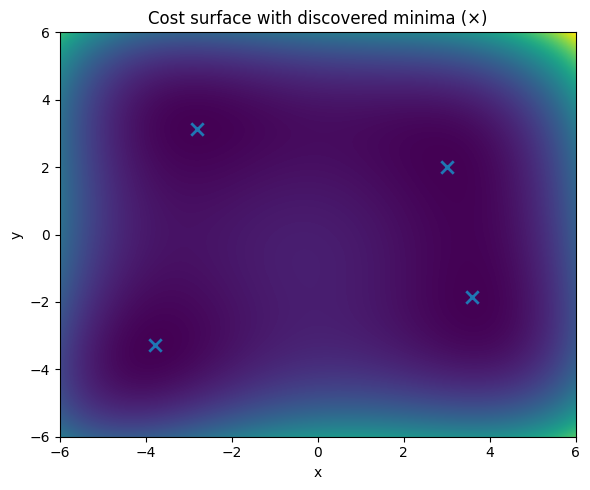

In [5]:
#!/usr/bin/env python3
"""
multi_sa.py  –  generic simulated-annealing local-minima finder

© 2025  Sadanand’s friendly ChatGPT helper.
"""

from __future__ import annotations
import numpy as np
import matplotlib.pyplot as plt


# --------------------------------------------------------------------------- #
# 1)  Generic optimiser                                                       #
# --------------------------------------------------------------------------- #
class Annealer:
    """
    Random-restart simulated-annealing + local-descent in any ℝⁿ.

    Parameters
    ----------
    cost_fn  : callable(x) → float
        Objective to minimise.  Accepts 1-D numpy array of length n.
    bounds   : tuple[(low, high), ...] | None
        Optional per-dimension (min, max) box.  If None, steps are unbounded.
    """

    def __init__(
        self,
        cost_fn,
        *,
        bounds=None,
        T0=10.0,
        alpha=0.98,
        step_size=0.5,
        sa_iters=5000,
        ls_step=1e-3,
        ls_iters=10_000,
        dedup_tol=1e-2,
    ):
        self.cost_fn = cost_fn
        self.bounds = bounds
        self.T0 = T0
        self.alpha = alpha
        self.step_size = step_size
        self.sa_iters = sa_iters
        self.ls_step = ls_step
        self.ls_iters = ls_iters
        self.dedup_tol = dedup_tol

    # ---------------- internal helpers ---------------- #
    def _clip(self, x: np.ndarray) -> np.ndarray:
        if self.bounds is None:
            return x
        clipped = x.copy()
        for i, (lo, hi) in enumerate(self.bounds):
            clipped[i] = np.clip(clipped[i], lo, hi)
        return clipped

    def _sa_single(self, start: np.ndarray, rng: np.random.Generator):
        x = start.astype(float, copy=True)
        e = self.cost_fn(x)
        best_x, best_e = x.copy(), e
        T = self.T0
        for _ in range(self.sa_iters):
            cand = x + rng.normal(scale=self.step_size, size=x.shape)
            cand = self._clip(cand)
            e_cand = self.cost_fn(cand)
            dE = e_cand - e
            if dE <= 0 or rng.random() < np.exp(-dE / T):
                x, e = cand, e_cand
                if e < best_e:
                    best_x, best_e = x.copy(), e
            T *= self.alpha
        return best_x

    def _local_descent(self, x: np.ndarray):
        e = self.cost_fn(x)
        for _ in range(self.ls_iters):
            improved = False
            for axis in range(len(x)):
                for direction in (-1, 1):
                    cand = x.copy()
                    cand[axis] += direction * self.ls_step
                    cand = self._clip(cand)
                    e_cand = self.cost_fn(cand)
                    if e_cand < e:
                        x, e = cand, e_cand
                        improved = True
            if not improved:
                break
        return x

    # ---------------- public API ---------------- #
    def find_minima(self, *, n_runs=50, seed=None):
        """
        Return list of distinct minima (np.ndarray) discovered over n_runs.
        """
        rng = np.random.default_rng(seed)
        pts = []
        for _ in range(n_runs):
            if self.bounds is None:
                start = rng.normal(size=len(pts) or 2)  # loose default
            else:
                lo = np.array([b[0] for b in self.bounds])
                hi = np.array([b[1] for b in self.bounds])
                start = rng.uniform(lo, hi)
            x_sa = self._sa_single(start, rng)
            x_min = self._local_descent(x_sa)
            pts.append(x_min)

        # deduplicate
        uniq = []
        for p in pts:
            if all(np.linalg.norm(p - q) > self.dedup_tol for q in uniq):
                uniq.append(p)
        return uniq


# --------------------------------------------------------------------------- #
# 2)  Demo cost function & visualisation                                      #
# --------------------------------------------------------------------------- #
def himmelblau(xy: np.ndarray) -> float | np.ndarray:
    """
    Vectorised Himmelblau 2-D test function – four global minima.
    """
    x, y = xy[..., 0], xy[..., 1]
    return (x**2 + y - 11) ** 2 + (x + y**2 - 7) ** 2


def plot_2d_cost(cost_fn, minima, xlim=(-6, 6), ylim=(-6, 6)):
    xs = np.linspace(*xlim, 400)
    ys = np.linspace(*ylim, 400)
    X, Y = np.meshgrid(xs, ys)
    Z = cost_fn(np.stack([X, Y], axis=-1))

    plt.figure(figsize=(6, 5))
    plt.imshow(
        Z,
        extent=[*xlim, *ylim],
        origin="lower",
        aspect="auto",
    )
    mins = np.array(minima)
    plt.scatter(mins[:, 0], mins[:, 1], marker="x", s=80, linewidths=2)
    plt.title("Cost surface with discovered minima (×)")
    plt.xlabel("x")
    plt.ylabel("y")
    plt.tight_layout()
    plt.show()


# --------------------------------------------------------------------------- #
# 3)  Plug-and-play demo                                                      #
# --------------------------------------------------------------------------- #
if __name__ == "__main__":
    # --- configure optimiser for the 2-D example ---
    bounds = [(-6, 6), (-6, 6)]
    sa = Annealer(
        himmelblau,
        bounds=bounds,
        T0=15.0,
        alpha=0.985,
        step_size=0.8,
        sa_iters=8000,
        ls_step=1e-3,
    )

    # --- find minima ---
    minima = sa.find_minima(n_runs=40, seed=123)

    # --- report ---
    print("Distinct minima:")
    for i, m in enumerate(minima, 1):
        print(f"{i:2d}: ({m[0]: .6f}, {m[1]: .6f})   cost = {himmelblau(m):.6f}")

    # --- visualise the 2-D landscape ---
    plot_2d_cost(himmelblau, minima)
